<a href="https://colab.research.google.com/github/Thomas19SA1247/Tugas-Self-Learning/blob/main/Jumat%2C%2007%20Oktober%202022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Movie Recommendation System**

Sistem pemberi rekomendasi adalah sistem pembelajaran mesin yang membantu pengguna menemukan produk dan layanan baru. Setiap kali Anda berbelanja online, sistem rekomendasi memandu Anda menuju produk yang paling mungkin Anda beli.

Komponen penting dari salah satu sistem ini adalah fungsi pemberi rekomendasi, yang mengambil informasi tentang pengguna dan memprediksi peringkat yang mungkin ditetapkan pengguna untuk suatu produk, misalnya. Memprediksi peringkat pengguna, bahkan sebelum pengguna benar-benar memberikannya, membuat sistem pemberi rekomendasi menjadi alat yang ampuh.

**Metode Recommender Systems**

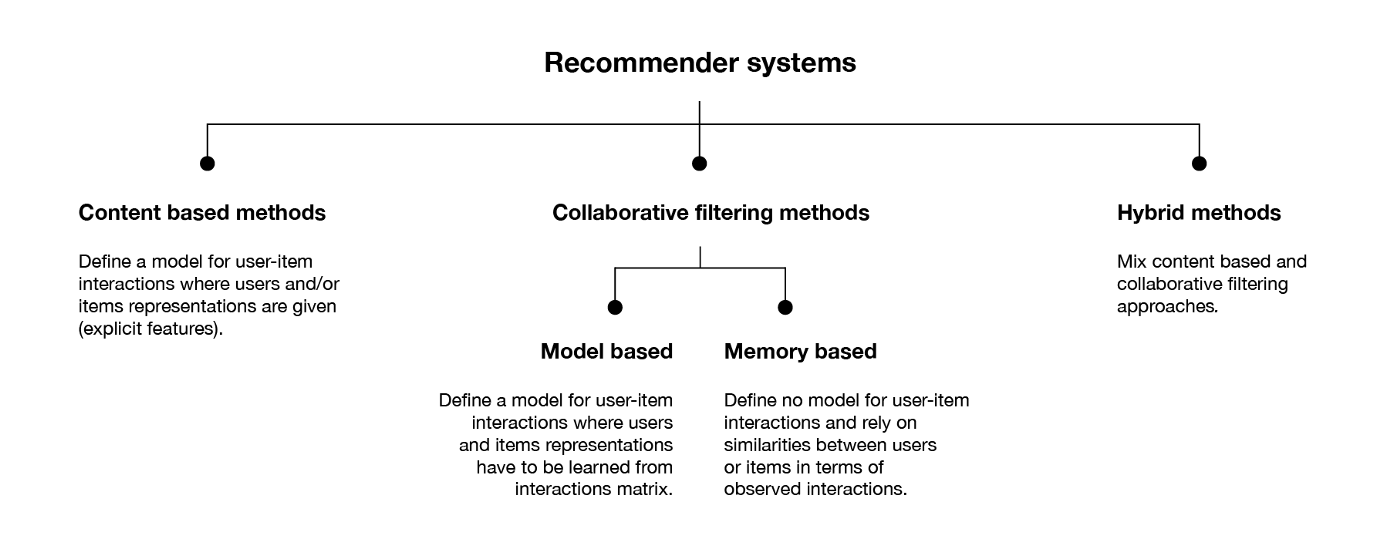

**Collaborative Filtering Methods**

**1.   Model Based Recommender Systems**


> Sistem rekomendasi berbasis model melibatkan pembuatan model berdasarkan kumpulan data peringkat. Dengan kata lain, kita mengekstrak beberapa informasi dari kumpulan data, dan menggunakannya sebagai "model" untuk membuat rekomendasi tanpa harus menggunakan kumpulan data lengkap setiap saat.

> Untuk sistem rekomendasi berbasis model kita akan menggunakan library yang disebut Surprise dan kita akan menggunakan SVD sebagai metode faktorisasi matriks.

    **Singular Value Decomposition (SVD)**
    Untuk sistem rekomendasi berbasis model kita akan menggunakan library yang disebut Surprise dan kita akan menggunakan SVD sebagai metode faktorisasi matriks.




**1. Import Libraries**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 6.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633972 sha256=98f02f7f28fcba5bf6e2960c9c4aea58616eb8353883013a29c03990c49a7643
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
from surprise import Dataset, Reader
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import accuracy

**2.   Import Library**

Dataset bisa di download [disini](https://drive.google.com/drive/folders/1dKy6uRcDbF7eWpqwvpwNKDcPY44Rikwx?usp=sharing)




In [4]:
ratings = pd.read_csv("ratings_small.csv")
movie_md = pd.read_csv("movies_metadata.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
# Dataframe movie dengan vote_count lebih dari 55
movie_md = movie_md[movie_md['vote_count']>55][['id','title']]

# IDs dari movies dengan count lebih dari 55
movie_ids = [int(x) for x in movie_md['id'].values]

# Pilih rating dengan vote lebih dari  55
ratings = ratings[ratings['movieId'].isin(movie_ids)]

# Reset Index
ratings.reset_index(inplace=True, drop=True)

# Cetak 5 baris pertama
ratings.head()

,userId,movieId,rating,timestamp
0,1,1371,2.5,1260759135
1,1,2105,4.0,1260759139
2,1,2294,2.0,1260759108
3,2,17,5.0,835355681
4,2,62,3.0,835355749


In [6]:
ratings.shape

(29965, 4)

In [7]:
# Inisialisasi objek surprise reader
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0,5), skip_lines=1)

# Load data
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

# Bangun objek trainset (lakukan ini hanya ketika Anda menggunakan seluruh dataset untuk training)
trainset = data.build_full_trainset()

In [8]:
# Inisialisasi model
svd = SVD()

# cross-validate
svd.fit(trainset)

In [9]:
# Cek Prediksi
svd.predict(uid=3,iid=2959,r_ui=5.0)

Prediction(uid=3, iid=2959, r_ui=5.0, est=4.150925471266243, details={'was_impossible': False})

In [10]:
svd.predict(uid=15,iid=2678,r_ui=1.0)

Prediction(uid=15, iid=2678, r_ui=1.0, est=2.8343122718738267, details={'was_impossible': False})

Ketika menggunakan metode **.predict()** di mana kita melewatkan 3 argumen, misalkan **userID(uid)**, **itemID(iid)** dan **r_ui(peringkat sebenarnya)**

Output dari setiap prediksi adalah tuple di mana est adalah peringkat perkiraan kami.

Kita dapat melihat bahwa model kita mampu berkinerja baik dan mampu membuat prediksi yang baik. Namun, model ini dapat lebih ditingkatkan dengan menggunakan teknik optimasi hyperparameter.

Sekarang setelah model kita siap, kita akan mengisi matriks interaksi item-pengguna dan akan membuat rekomendasi.

In [11]:
def get_recommendations(data, movie_md, user_id, top_n, algo):
    
    # membuat daftar kosong untuk menyimpan id produk yang direkomendasikan
    recommendations = []
    
    # membuat interactions item user
    user_movie_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # mengekstrak id produk yang belum berinteraksi dengan user_id
    non_interacted_movies = user_movie_interactions_matrix.loc[user_id][user_movie_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # mengulang setiap id produk yang user_id belum berinteraksi
    for item_id in non_interacted_movies:
        
        # memprediksi peringkat untuk id produk yang tidak berinteraksi oleh pengguna ini
        est = algo.predict(user_id, item_id).est
        
        # menambahkan peringkat yang diprediksi
        movie_name = movie_md[movie_md['id']==str(item_id)]['title'].values[0]
        recommendations.append((movie_name, est))

    # menyortir peringkat yang diprediksi dalam urutan menurun
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # kembalikan produk peringkat teratas dan prediksi tertinggi untuk pengguna ini

In [12]:
get_recommendations(data=ratings,movie_md=movie_md, user_id=654, top_n=10, algo=svd)

[('Galaxy Quest', 5),
 ('Hard Target', 4.935085984344886),
 ('Dead Man', 4.867133509456513),
 ('Cold Mountain', 4.8550276156916805),
 ('While You Were Sleeping', 4.847639470268426),
 ('The Thomas Crown Affair', 4.847401446025562),
 ('Nell', 4.841414556752295),
 ('The Sixth Sense', 4.80481822723703),
 ('Hannibal Rising', 4.796267189795856),
 ('The Thomas Crown Affair', 4.795306255401316)]

**2.   Memory Based Recommender System** 

> Metode berbasis memori menggunakan data historis peringkat pengguna untuk menghitung kesamaan antara pengguna atau item. Ide di balik metode ini adalah untuk menentukan ukuran kesamaan antara pengguna atau item, dan menemukan yang paling mirip untuk merekomendasikan item yang tidak terlihat. Sistem rekomendasi berbasis memori terdiri dari 2 jenis :

**1. User-based**
    
Dalam metode rekomendasi berbasis pengguna, kita akan menghitung kesamaan antara pengguna dan akan mengambil pengguna yang paling mirip menggunakan algoritma (KNN) dan akan merekomendasikan film yang disukai pengguna ke pengguna lain dan sebaliknya


**Import Libraries**

In [13]:
from surprise.prediction_algorithms.knns import KNNBasic

In [14]:
# Mendeklarasikan opsi kesamaan.
sim_options = {'name': 'cosine',
               'user_based': True}

# Algoritma KNN digunakan untuk menemukan item serupa
sim_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=33)

# Train algoritma di trainset, dan prediksi peringkat untuk testset
sim_user.fit(trainset)

In [15]:
# memprediksi peringkat untuk pengguna sampel dengan produk yang berinteraksi.
sim_user.predict(uid=2,iid=17,r_ui=5.0)

Prediction(uid=2, iid=17, r_ui=5.0, est=4.166335018545322, details={'actual_k': 40, 'was_impossible': False})

In [16]:
# memprediksi peringkat untuk pengguna sampel dengan produk yang berinteraksi
sim_user.predict(uid=671,iid=4011,r_ui=4.0)

Prediction(uid=671, iid=4011, r_ui=4.0, est=4.262454431125302, details={'actual_k': 40, 'was_impossible': False})

In [17]:
get_recommendations(ratings, movie_md, 671,10,sim_user)

[('The Wizard', 5),
 ('Rio Bravo', 5),
 ('The Celebration', 5),
 ('Spider-Man 3', 5),
 ('A Streetcar Named Desire', 5),
 ('Gentlemen Prefer Blondes', 5),
 ('The Evil Dead', 5),
 ('JFK', 5),
 ('Strangers on a Train', 5),
 ("Singin' in the Rain", 5)]


**2. Item-based**
Dalam metode rekomendasi berbasis item, kita akan menghitung kesamaan antara item (film) dan akan mengambil item (film) yang paling mirip menggunakan algoritme (KNN) dan akan merekomendasikan item (film) yang disukai oleh satu pengguna kepada pengguna lain yang menyukai jenis yang serupa. item (film) dan sebaliknya.

In [18]:
# Mendeklarasikan similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm digunakan untuk menemukan barang serupa
sim_item = KNNBasic(sim_options=sim_options, verbose=False, random_state=33)

# Train algoritma di trainset, dan prediksi peringkat untuk testset
sim_item.fit(trainset)

In [19]:
# memprediksi peringkat untuk pengguna sampel dengan produk yang berinteraksi
sim_item.predict(uid=2,iid=17,r_ui=5.0)

Prediction(uid=2, iid=17, r_ui=5.0, est=3.650476877827318, details={'actual_k': 40, 'was_impossible': False})

In [20]:
# memprediksi peringkat untuk pengguna sampel dengan produk yang berinteraksi
sim_item.predict(uid=671,iid=4011,r_ui=4.0)

Prediction(uid=671, iid=4011, r_ui=4.0, est=4.164142698155605, details={'actual_k': 31, 'was_impossible': False})

In [21]:
get_recommendations(ratings, movie_md, 671,10,sim_item)

[('Hard Candy', 5),
 ('Visitor Q', 5),
 ('The Protector', 4.666666666666667),
 ('Shaun of the Dead', 4.571428571428571),
 ('The Silence of the Lambs', 4.503228000162119),
 ("Singin' in the Rain", 4.5),
 ("Hearts of Darkness: A Filmmaker's Apocalypse", 4.5),
 ('Sense and Sensibility', 4.5),
 ("The Hitchhiker's Guide to the Galaxy", 4.5),
 ('Fantasia', 4.428571428571429)]